In [1]:
import os, random, time, multiprocessing, glob, cv2, numpy as np, pandas as pd, nibabel as nib, matplotlib.pylab as plt, matplotlib.colors as mcolors

# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
# Torchvision library
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from utilities import *
from preprocessing_utilities import *

from tqdm import tqdm

In [2]:
idx = 77
patient_id = '00000'

In [3]:
flair = nib.load('./BraTS/BraTS2021_Training_Data/BraTS2021_' + patient_id + '/BraTS2021_' + patient_id + '_flair.nii.gz').get_fdata()[:,:,idx]
seg = nib.load('./BraTS/BraTS2021_Training_Data/BraTS2021_' + patient_id + '/BraTS2021_' + patient_id + '_seg.nii.gz').get_fdata()[:,:,idx]

(-0.5, 239.5, 239.5, -0.5)

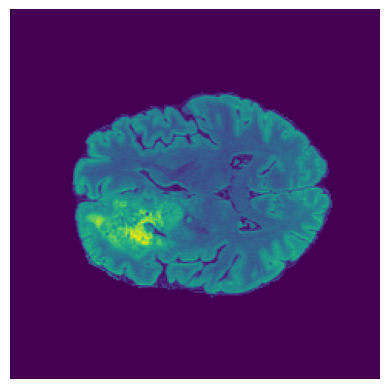

In [4]:
plt.imshow(flair)
plt.axis('off')

(-0.5, 239.5, 239.5, -0.5)

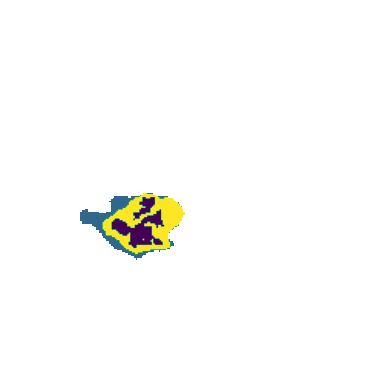

In [5]:
plt.imshow(np.ma.masked_where(seg == 0, seg), alpha=1, vmin=1, vmax=4)
plt.axis('off')

(-0.5, 239.5, 239.5, -0.5)

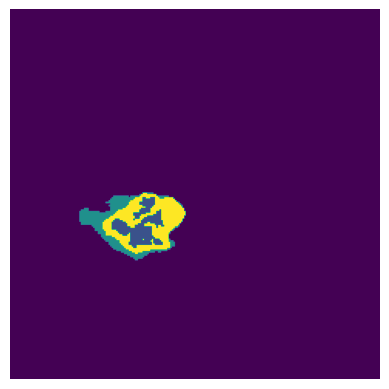

In [6]:
plt.imshow(seg)
plt.axis('off')

(-0.5, 239.5, 239.5, -0.5)

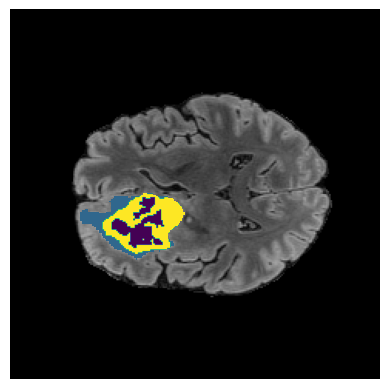

In [7]:
plt.imshow(flair, cmap='gray')
masked_true = np.ma.masked_where(seg == 0, seg)
plt.imshow(masked_true, alpha=1, vmin=1, vmax=4)
plt.axis('off')

In [8]:
flair = np.load('./BraTS/BraTS2021_Training_Data_Slice/BraTS2021_' + patient_id + '/flair/BraTS2021_' + patient_id + '_flair_' + str(idx) + '.npy')
seg = np.load('./BraTS/BraTS2021_Training_Data_Slice/BraTS2021_' + patient_id + '/seg/BraTS2021_' + patient_id + '_seg_' + str(idx) + '.npy')

(-0.5, 63.5, 63.5, -0.5)

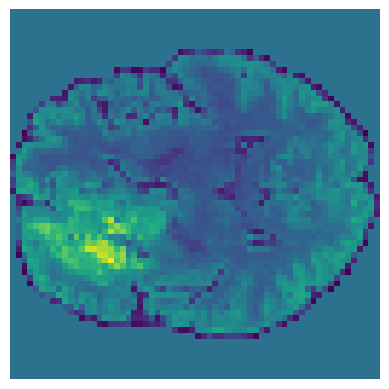

In [9]:
plt.imshow(flair)
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

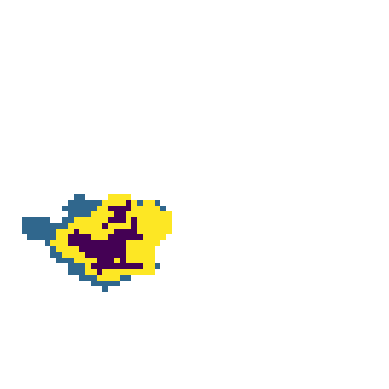

In [10]:
plt.imshow(np.ma.masked_where(seg == 0, seg), alpha=1, vmin=1, vmax=4)
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

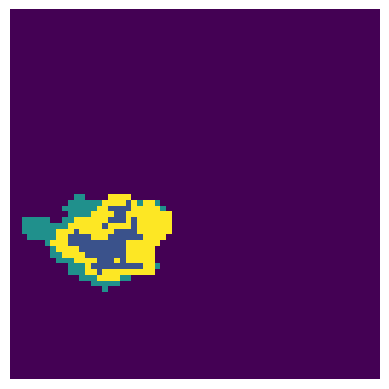

In [11]:
plt.imshow(seg)
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

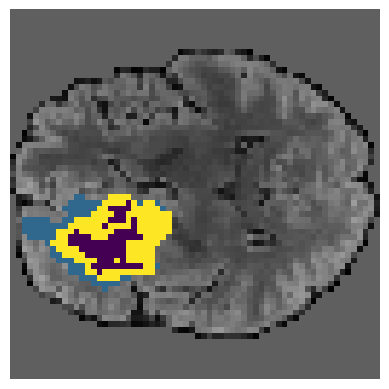

In [12]:
plt.imshow(flair, cmap='gray')
masked_true = np.ma.masked_where(seg == 0, seg)
plt.imshow(masked_true, alpha=1, vmin=1, vmax=4)
plt.axis('off')

In [13]:
N_EPOCHS = 40
batch_size = 64
scan_type = 'Flair'
master_path = r'./BraTS/'

SEED = 44
USE_SEED = True

# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
   device = torch.device('mps')
else:
    device = torch.device('cpu')

def set_seed(seed, use_cuda = True, use_mps = False):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    if use_mps:
        torch.mps.manual_seed(seed)

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available(), torch.backends.mps.is_available())

## Define Custom Dataset
class BraTSDataset(Dataset):
    def __init__(self, image_path = r'./BraTS/BraTS2021_Training_Data_Slice', transform=None):
        'Initialisation'
        self.image_path = image_path
        self.folders_name = [folder for folder in os.listdir(self.image_path) if folder != '.DS_Store']
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.folders_name) * 155

    def __getitem__(self, index):
        'Generates one sample of data'

        # Determine the image index and the RGB layer
        image_idx = index // 155
        layer_idx = index % 155

        # Select sample
        file_name = self.folders_name[image_idx]
        
        path_img = os.path.join(self.image_path, file_name, scan_type.lower(), file_name + '_' + scan_type.lower() + '_' + str(layer_idx+1) + '.npy')
        image = np.load(path_img).astype(np.float32)

        path_label = os.path.join(self.image_path, file_name, 'seg', file_name + '_seg_' + str(layer_idx+1) + '.npy')
        label = np.load(path_label)
        
        if self.transform:
            image, label = self.transform([image, label])
        return image, label
    
class BinariseLabel(object):
    def __call__(self, sample):
        image, label = sample
        new_label = np.sign(label)
        return image, new_label

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample
        return torch.from_numpy(image), torch.from_numpy(label)
    
dataset = BraTSDataset(image_path = r'./BraTS/BraTS2021_Training_Data_Slice',
                        transform=transforms.Compose([
                            BinariseLabel(),
                            ToTensor()
                        ]))

In [14]:
[folder for folder in os.listdir(r'./BraTS/BraTS2021_Training_Data_Slice') if folder != '.DS_Store'][[folder for folder in os.listdir(r'./BraTS/BraTS2021_Training_Data_Slice') if folder != '.DS_Store'].index('BraTS2021_' + patient_id)]

'BraTS2021_00000'

In [15]:
ind = [folder for folder in os.listdir(r'./BraTS/BraTS2021_Training_Data_Slice') if folder != '.DS_Store'].index('BraTS2021_' + patient_id)
ind

661

In [16]:
test_indices = []
for i in range(155):
    test_indices.append(ind*155 + i)

test_subset = Subset(dataset, test_indices)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [17]:
## Define Convlutional Autoencoder Structure
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      ## encoder layers ##
      # conv layer (depth from 1 --> 4), 3x3 kernels
      # Input 64 x 64
      nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding = 'same'), # 64 x 64
      nn.ReLU(),
      # pooling layer to reduce x-y dims by two; kernel and stride of 2
      nn.MaxPool2d(2), ## 32 x 32
      # conv layer (depth from 4 --> 8), 4x4 kernels
      nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding = 'same'), # 32 x 32
      nn.ReLU(),
      nn.MaxPool2d(2), # 16 x 16
      # conv layer (depth from 8 --> 12), 5x5 kernels
      nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding = 'same'), # ( 12 x ) 16 x 16
      nn.ReLU(),
      
      ## decoder layers ##
      # add transpose conv layers, with relu activation function
      nn.ConvTranspose2d(12, 6, kernel_size = 2, stride=2), # 32 x 32
      nn.ReLU(),
      nn.ConvTranspose2d(6, 1, kernel_size = 2, stride=2), # 64 x 64
      # output layer (with sigmoid for scaling from 0 to 1)
      # nn.Sigmoid()
    )
    
  def forward(self, x):
    x = x.view(int(np.prod(x.shape)/(64**2)), 1, 64, 64)
    x = self.features(x)
    return x
model = ConvAutoencoder().to(device)

## Loss function and Optimisation Methods
# Loss
criterion = torch.nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

# Optim
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

# Load the trained parameters
model.load_state_dict(torch.load(f'./models/CA_{scan_type}.pt'))
model.to(device)

ConvAutoencoder(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): ConvTranspose2d(12, 6, kernel_size=(2, 2), stride=(2, 2))
    (9): ReLU()
    (10): ConvTranspose2d(6, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)

In [18]:
labels, preds = predict(model, test_dataloader, device)

In [19]:
# Define the two colors
black = '#000000'
white = '#FFFFFF'
yellow = '#F9E855'

# Create a custom colormap
cmap = mcolors.ListedColormap([white, yellow])

(-0.5, 63.5, 63.5, -0.5)

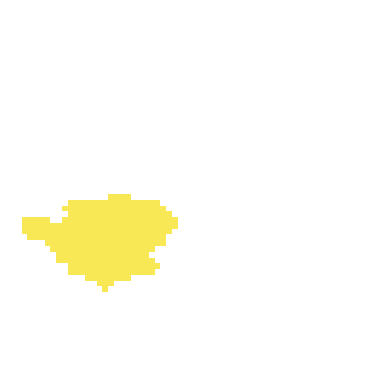

In [20]:
plt.imshow(labels[idx], cmap=cmap)
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

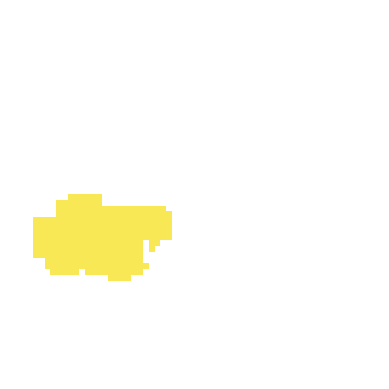

In [21]:
plt.imshow(preds[idx], cmap=cmap)
plt.axis('off')

In [22]:
yellow_colour = mcolors.ListedColormap(yellow)

(-0.5, 63.5, 63.5, -0.5)

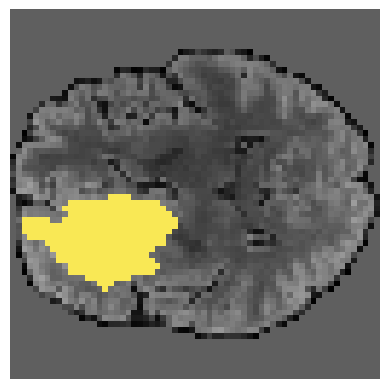

In [23]:
plt.imshow(flair, cmap='gray')
masked_true = np.ma.masked_where(labels[idx] == 0, labels[idx])
plt.imshow(masked_true, cmap = yellow_colour, alpha=1, vmin=1, vmax=1)
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

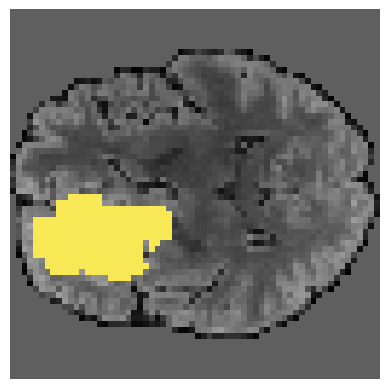

In [24]:
plt.imshow(flair, cmap='gray')
masked_pred = np.ma.masked_where(preds[idx] == 0, preds[idx])
plt.imshow(masked_pred, cmap = yellow_colour, alpha=1, vmin=1, vmax=1)
plt.axis('off')

In [25]:
rows_indices = torch.where(labels[idx])[0]
cols_indices = torch.where(labels[idx])[1]

top_row = torch.min(rows_indices)
bottom_row = torch.max(rows_indices)
left_col = torch.min(cols_indices)
right_col = torch.max(cols_indices)

width = right_col - left_col + 1
height = bottom_row - top_row + 1

if width > height:
    top_row = top_row - np.floor((width - height) / 2)
    bottom_row = bottom_row + np.ceil((width - height) / 2)
    if top_row < 0:
        bottom_row = bottom_row - top_row
        top_row = 0
    elif bottom_row > 63:
        top_row = top_row - (bottom_row - 63)
        bottom_row = 63
elif height > width:
    left_col = left_col - np.floor((height - width) / 2)
    right_col = right_col + np.ceil((height - width) / 2)
    if left_col < 0:
        right_col = right_col - left_col
        left_col = 0
    elif right_col > 63:
        left_col = left_col - (right_col - 63)
        right_col = 63

crop_idx_true = [int(top_row), int(bottom_row), int(left_col), int(right_col)]

(-0.5, 26.5, 26.5, -0.5)

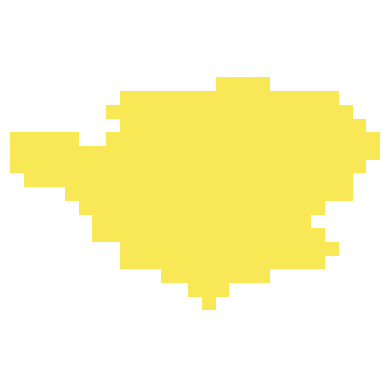

In [26]:
plt.imshow(labels[idx][crop_idx_true[0]:crop_idx_true[1]+1, crop_idx_true[2]:crop_idx_true[3]+1], cmap = cmap)
plt.axis('off')

In [27]:
rows_indices = torch.where(preds[idx])[0]
cols_indices = torch.where(preds[idx])[1]

top_row = torch.min(rows_indices)
bottom_row = torch.max(rows_indices)
left_col = torch.min(cols_indices)
right_col = torch.max(cols_indices)

width = right_col - left_col + 1
height = bottom_row - top_row + 1

if width > height:
    top_row = top_row - np.floor((width - height) / 2)
    bottom_row = bottom_row + np.ceil((width - height) / 2)
    if top_row < 0:
        bottom_row = bottom_row - top_row
        top_row = 0
    elif bottom_row > 63:
        top_row = top_row - (bottom_row - 63)
        bottom_row = 63
elif height > width:
    left_col = left_col - np.floor((height - width) / 2)
    right_col = right_col + np.ceil((height - width) / 2)
    if left_col < 0:
        right_col = right_col - left_col
        left_col = 0
    elif right_col > 63:
        left_col = left_col - (right_col - 63)
        right_col = 63

crop_idx = [int(top_row), int(bottom_row), int(left_col), int(right_col)]

In [28]:
crop_idx

[28, 51, 4, 27]

(-0.5, 23.5, 23.5, -0.5)

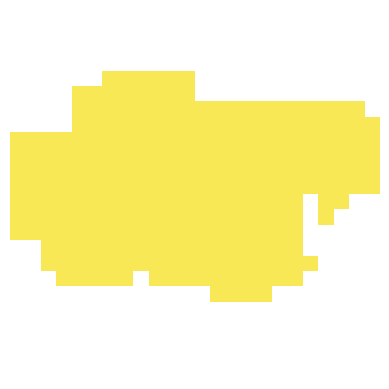

In [29]:
plt.imshow(preds[idx][crop_idx[0]:crop_idx[1]+1, crop_idx[2]:crop_idx[3]+1], cmap=cmap)
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

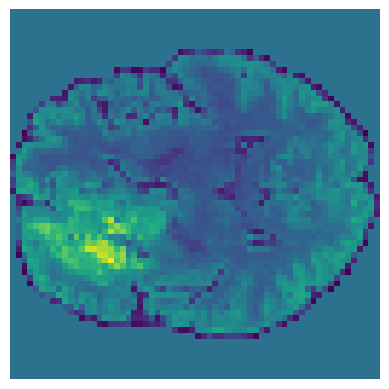

In [30]:
plt.imshow(flair)
plt.axis('off')

In [31]:
flair_cropped = cv2.resize(flair[crop_idx[0]:crop_idx[1]+1, crop_idx[2]:crop_idx[3]+1], [64,64], interpolation = cv2.INTER_NEAREST)

(-0.5, 63.5, 63.5, -0.5)

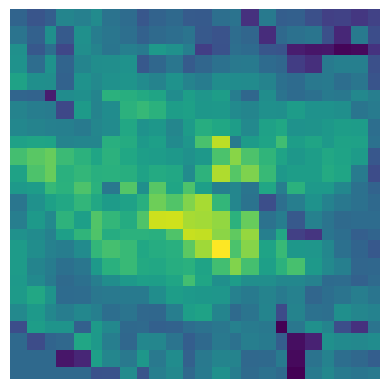

In [32]:
plt.imshow(flair_cropped)
plt.axis('off')

In [33]:
class SingleImageDataset(Dataset):
    def __init__(self, image_tensor):
        self.image_tensor = torch.from_numpy(image_tensor.astype(np.float32))

    def __len__(self):
        return 1  # As we only have one image

    def __getitem__(self, idx):
        # The image tensor is already loaded, so just return it.
        return self.image_tensor, self.image_tensor

In [34]:
dataset = SingleImageDataset(flair_cropped)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [35]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        ## Input is 64 x 64 x 1
        ## Output is 64 x 64 x 4
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3 64 x 64 x 1
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # output: 30x30x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, 4, kernel_size=1)

    def forward(self, x):
        x = x.view(x.shape[0], 1, 64, 64)
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

model = UNet().to(device)

# Loss
criterion = torch.nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

# Optim
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

model.load_state_dict(torch.load(f'./models/Unet_{scan_type}.pt'))
model.to(device)

UNet(
  (e11): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

In [36]:
_, preds_UNet = predict(model, dataloader, device)

In [37]:
def rebuild_prediction(image):
    image = torch.argmax(image, dim=0)
    image = torch.where(image == 3, torch.tensor(4), image)
    return image

In [38]:
pred_cropped = rebuild_prediction(preds_UNet[0])

(-0.5, 63.5, 63.5, -0.5)

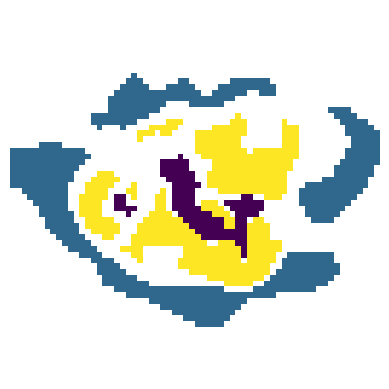

In [39]:
plt.imshow(np.ma.masked_where(pred_cropped == 0, pred_cropped), alpha=1, vmin=1, vmax=4)
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

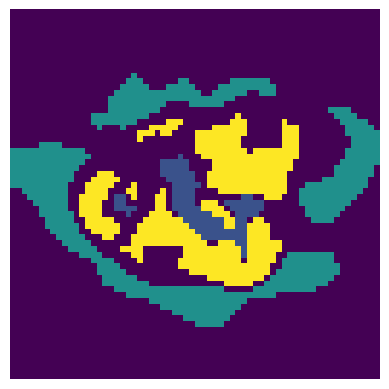

In [40]:
plt.imshow(pred_cropped)
plt.axis('off')

In [41]:
def resize_prediction(pred, crop_idx):
    top_row, bottom_row, left_col, right_col = crop_idx
    # resize pred
    org_size = bottom_row - top_row + 1
    pred_resize = cv2.resize(pred.numpy(), [org_size, org_size], interpolation=cv2.INTER_NEAREST)
    pred = np.zeros((64, 64))
    if top_row > 0:
        top_row, bottom_row = top_row - 1, bottom_row - 1
    if left_col > 0:
        left_col, right_col = left_col - 1, right_col - 1
    if bottom_row - top_row == right_col - left_col:
        pred[top_row:bottom_row+1, left_col:right_col+1] = pred_resize
    elif bottom_row - top_row > right_col - left_col:
        pred[top_row:bottom_row, left_col:right_col+1] = pred_resize
    else:
        pred[top_row:bottom_row+1, left_col:right_col] = pred_resize
    return pred

In [42]:
pred_org_size = resize_prediction(pred_cropped, crop_idx)

(-0.5, 63.5, 63.5, -0.5)

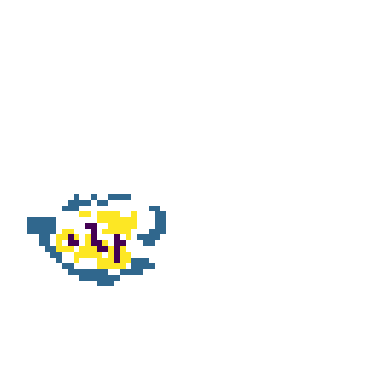

In [43]:
plt.imshow(np.ma.masked_where(pred_org_size == 0, pred_org_size), alpha=1, vmin=1, vmax=4)
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

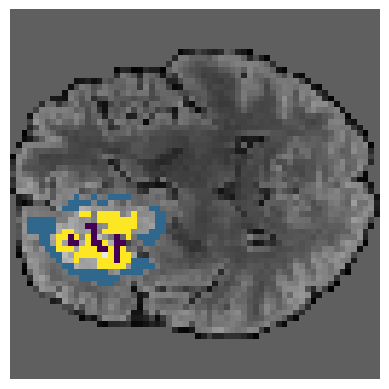

In [44]:
plt.imshow(flair, cmap='gray')
masked_pred_org_size = np.ma.masked_where(pred_org_size == 0, pred_org_size)
plt.imshow(masked_pred_org_size, alpha=1, vmin=1, vmax=4)
plt.axis('off')